In [1]:
using DataFrames, Query, JSON3, HTTP, VegaLite, Dates, CSV, StatsPlots, LsqFit
using Statistics: mean, median
ENV["COLUMNS"] = 1000
ENV["ROWs"] = 600
vltime(d) = datetime2unix(d)*1e3
sigm(x, p) = @. p[1] / (1.0 + exp(-p[2]*(x-p[3])))

sigm (generic function with 1 method)

# World

In [2]:
js_world = download("https://pomber.github.io/covid19/timeseries.json") |> read |> String |> JSON3.read;
function make_df(country)
    js_p = js_world[country]
    df = DataFrame(date=Date[], positive=Int64[], death=Int64[], recovered = Int64[], country = String[])
    for each in js_p
        push!(df, [Date(each["date"], "yyyy-mm-dd"), each["confirmed"], each["deaths"], each["recovered"], String(country)])
    end
    df
end

make_df (generic function with 1 method)

In [3]:
df_world = vcat(map(make_df, keys(js_world)|>collect)...);

In [4]:
df_world_population = CSV.File("World_TotalPopulation.csv") |> @filter(_.Variant=="Medium" && _.Time==2020) |> 
DataFrame |> @select(:Location, :PopTotal) |> DataFrame

rename!(df_world_population, :Location => :country)
df_world_population.country .= replace(df_world_population.country, "United States of America" => "US");

In [5]:
# df_world = join(df_world, df_world_population, on=:country)
first(df_world, 3)

,date,positive,death,recovered,country
,Date,Int64,Int64,Int64,String
1,2020-01-22,0,0,0,Afghanistan
2,2020-01-23,0,0,0,Afghanistan
3,2020-01-24,0,0,0,Afghanistan


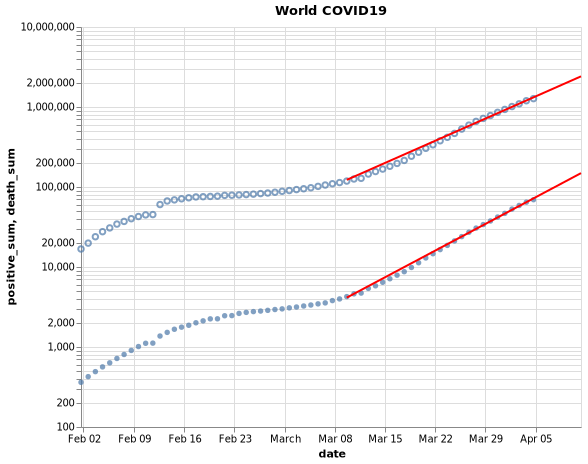

In [6]:
by(df_world, :date, [:positive=>sum, :death=>sum]) |> @filter(_.date > Date(2020, 2, 1)) |>
@vlplot(
    title = "World COVID19",
    width=500, height=400,
    x = :date,
    layer=[
        {        
            :point,
            y = {:positive_sum, scale={type=:log}},
        },
        {
            :circle,
            y = :death_sum,
        },
        {
            transform=[
                {
                    filter= {field = :date, gt = vltime(now()-Day(15))}
                },
                {
                    regression=:positive_sum,
                    on=:date,
                    groupby=[:country],
                    method=:exp,
                    extent=[vltime(DateTime(2020, 3,10)), vltime(now()+Day(5))]
                }
            ],
            mark={:line, color="red",style=:dashed, strokeDash=8},
            y=:positive_sum,
        },
        {
            transform=[
                {
                    filter= {field = :date, gt = vltime(now()-Day(15))}
                },
                {
                    regression=:death_sum,
                    on=:date,
                    groupby=[:country],
                    method=:exp,
                    extent=[vltime(DateTime(2020, 3,10)), vltime(now()+Day(5))]
                }
            ],
            mark={:line, color="red", style=:dashed, strokeDash=8},
            y=:death_sum,
        }
        
    ]
)

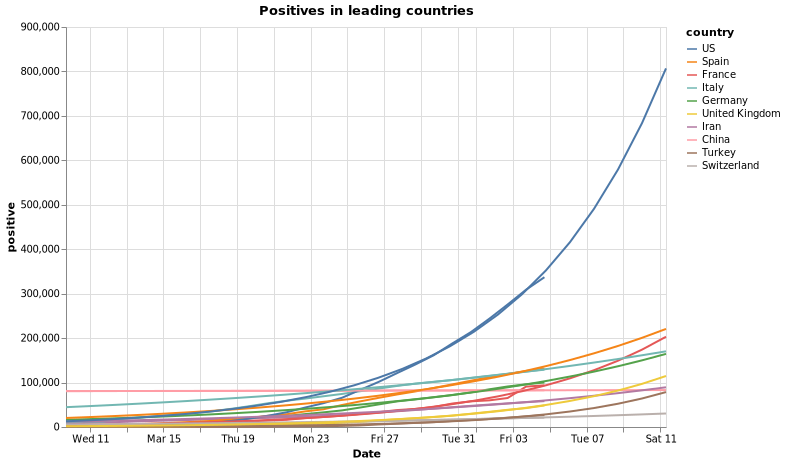

In [7]:
df_world |> @filter(_.date > Date(2020, 3, 9) && _.country ∈ unique(df_world[df_world.positive.>2e4, :country]) ) |>
@vlplot(
    layer=[{
        :line,
        height = 400, width=600,
        x = {:date, timeUnite = :yearmonthdate},
        y = {:positive},
        color = {:country, sort= {op=:max, field=:positive, order=:descending}},
        title = "Positives in leading countries"
    },
    {
        transform=[
            {
                filter= {field = :date, gt = vltime(now()-Day(10))}
            },
            {
                regression=:positive,
                on=:date,
                groupby=[:country],
                method=:exp,
                extent=[vltime(DateTime(2020, 3,10)), vltime(now()+Day(5))]
            }
        ],
        mark={:line, style=:dashed, strokeDash=8},
        x = {:date, title="Date", timeUnite = :yearmonthdate},
        y=:positive,
        color = {:country, sort= {op=:max, field=:positive, order=:descending}},
    }
    ]
)

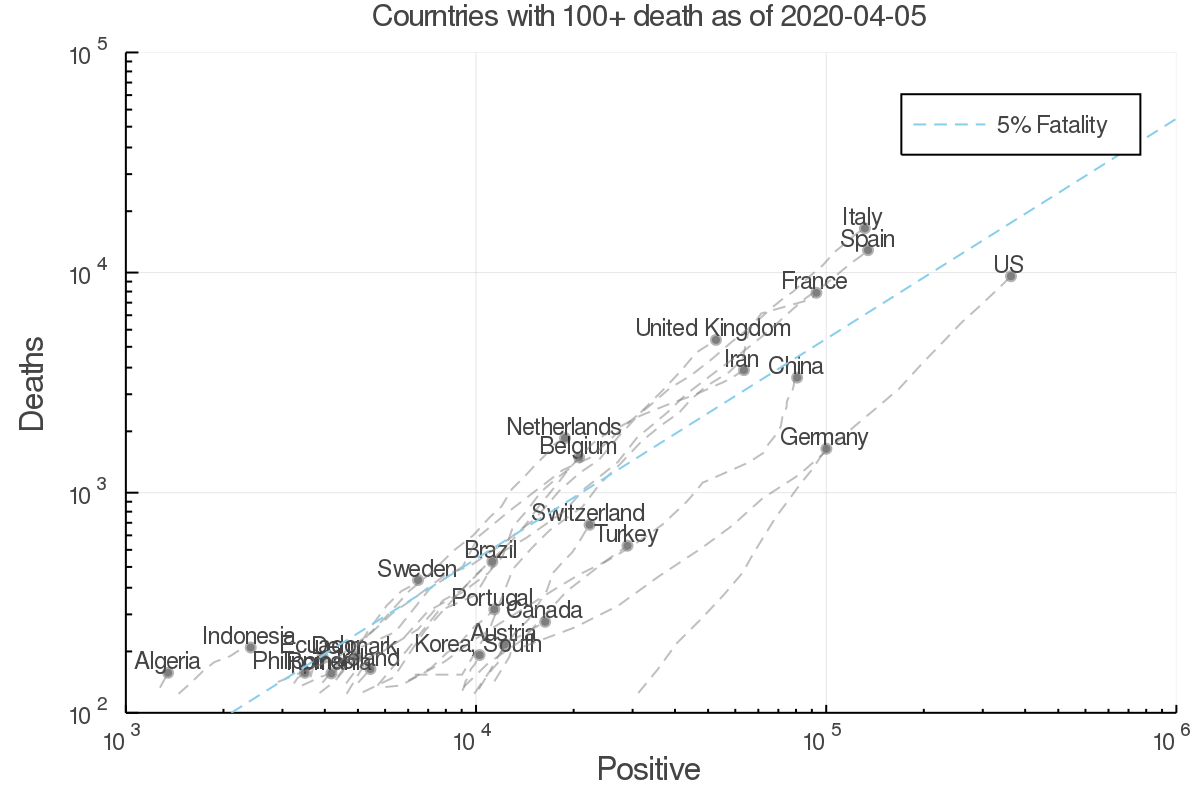

In [8]:
da = today()
function wee(da)
    df_temp = df_world |> @filter( _.positive >1100 && _.death >120 && _.date <= da) |> @orderby(:country)
    plot(
        title = "Courntries with 100+ death as of $da",
        titlefont = 10,
        size = (600, 400),
        xlabel = "Positive",
        ylabel = "Deaths", 
        xscale=:log10,
        yscale=:log10,
        xlims = (1e3, 1e6),
        ylims = (1e2, 1e5),
        minorticks = 10,
        dpi = 200,
        fmt=:png
    )
    @df df_temp |> @filter(_.date == da) scatter!(:positive, :death, color = "black", markeralpha=0.3, markersize=2.5, series_annotations=[Plots.text(x,:bottom, 8) for x in :country], group=:country, label="")
    @df df_temp plot!(:positive, :death, ls=:dash, color = "grey", group=:country, alpha=0.5, label="")
end

# anim = @animate for da in range(Date(2020, 3,1), df_world.date[end], step=Day(1))
#     wee(da)
# end
# gif(anim, fps = 4);
wee(df_world.date[end])
# df_temp = df_world |> @filter( _.country == "France" && _.positive >10 && _.death >10 && _.date <= df_world.date[end])
# @df df_temp |> @filter(_.date == df_world.date[end]) scatter!(:positive, :death, color = "red", markeralpha=1, markersize=2.5, series_annotations=[Plots.text(x,:bottom, 8) for x in :country], group=:country)
# @df df_temp plot!(:positive, :death, color = "red", group=:country, alpha=1, label="", leg=:topleft)
plot!(x->0.05*x,  ls=:dash, color = "skyblue", label = "5% Fatality")

In [9]:
last(df_world |> @filter(_.country == "Italy") |> DataFrame, 2)

,date,positive,death,recovered,country
,Date,Int64,Int64,Int64,String
1,2020-04-04,124632,15362,20996,Italy
2,2020-04-05,128948,15887,21815,Italy


# Tracker.com

In [10]:
df_s = download("http://covidtracking.com/api/states/daily.csv") |> CSV.File |> DataFrame
newest_daily = DateTime(df_s.dateChecked[1], "yyyy-mm-ddTHH:MM:SSZ")
newest_daily < Date(2020, 2, 20)
df_s.date = map(x->Date(string(x), "yyyymmdd"), df_s.date)


df_new = download("https://covidtracking.com/api/v1/states/current.csv") |> CSV.File |> DataFrame
prev = DateTime(df_s.dateChecked[1], "yyyy-mm-ddTHH:MM:SSZ")
df_new.lastUpdateEt = map(x -> DateTime(x, "mm/dd HH:MM") + Year(2019), df_new.lastUpdateEt)
df_new[!, :date] .= today()
newtemp = df_new[df_new.lastUpdateEt .> prev, :];

thread = 3 warning: only found 24 / 25 columns on data row: 475. Filling remaining columns with `missing`


In [11]:
sort(df_s, :date, rev=true) |> first

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,hash,dateChecked,death,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
,Date,String,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,String,String,Int64⍰,Int64⍰,Int64,Int64,Int64,Int64,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰
1,2020-04-05,AK,185,6099,missing,missing,20,missing,missing,missing,missing,missing,661d7b0f627847a2dceb5d70d4e9260965031cc2,2020-04-05T20:00:00Z,6,20,6284,6284,6284,2,1,4,230,14,244


In [12]:
df_s = vcat(df_s, newtemp ; cols=:intersect);
df_s.positive = replace(df_s.positive, missing=>1e-6)
df_s.negative = replace(df_s.negative, missing=>1e-6)
df_s.total = replace(df_s.total, missing=>1e-6)
df_s.death = replace(df_s.death, missing=>1e-6)
first(df_s, 3)

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,hash,dateChecked,death,hospitalized,total,totalTestResults,posNeg,fips
,Date,String,Float64,Float64,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,String,String,Float64,Int64⍰,Float64,Int64,Int64,Int64
1,2020-04-05,AK,185.0,6099.0,missing,missing,20,missing,missing,missing,missing,missing,661d7b0f627847a2dceb5d70d4e9260965031cc2,2020-04-05T20:00:00Z,6.0,20,6284.0,6284,6284,2
2,2020-04-05,AL,1796.0,11282.0,missing,missing,231,missing,missing,missing,missing,missing,3f2c1f28926eeadf623d04aeb3716d29c5394d3c,2020-04-05T20:00:00Z,45.0,231,13078.0,13078,13078,1
3,2020-04-05,AR,830.0,10412.0,missing,67,130,missing,43,27,39,97,3796ddde6259ef7ec36ee05d5793202c57b91aba,2020-04-05T20:00:00Z,16.0,130,11242.0,11242,11242,5


p_f = [483390.99512013135, 0.24174444168874604, 737516.882933449]
s_e = [60924.705840229035, 0.023760984595949736, 1.213204294088109]


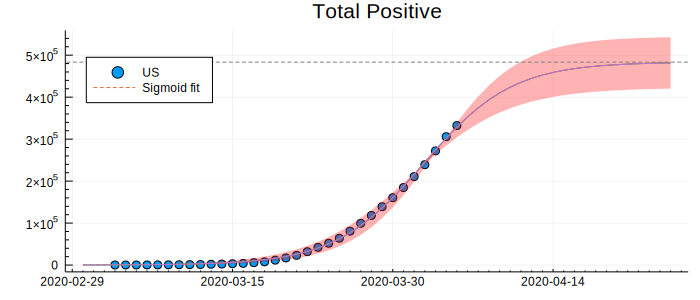

In [13]:
sigm_fun(p) = @. x -> p[1] / (1.0 + exp(-p[2]*(x-p[3])))
df_us_test = sort(by(df_s, [:date], :positive=>sum), :date) |> @filter(_.date < today()) |> DataFrame
b, e = df_us_test.date[1], df_us_test.date[end]
offset = mean(Dates.value.([b,e]))
# @show offset
xs = Dates.value.(df_us_test.date)
extend_x = Dates.value.(range(b-Day(3), e+Day(20), step=Day(1)))

@df df_us_test scatter(:date, :positive_sum, label="US", title="Total Positive")
fit = curve_fit(sigm, xs, df_us_test.positive_sum, [1e6, 0.01, offset])
p_f = coef(fit)
s_e = margin_error(fit, 0.01) #certainty level 99%
@show p_f
@show s_e
ys = extend_x |> sigm_fun(p_f)
rb_u =  extend_x |> sigm_fun(p_f.+s_e)
rb_d = extend_x |> sigm_fun(p_f.-s_e)
plot!(extend_x, ys, xminorticks=15, size=(700, 300),
      label="Sigmoid fit", ls=:dash, leg=:topleft, yminorticks=5)
plot!(extend_x, [ys ys],
      fillrange=[rb_d, rb_u], label="", fillcolor=:red, fillalpha=0.3)
# plot!(extend_x, fillrange=[rb_d, rb_u], label="", fill=(:orange))
hline!([p_f[1]], ls=:dash, color=:grey, label="" )

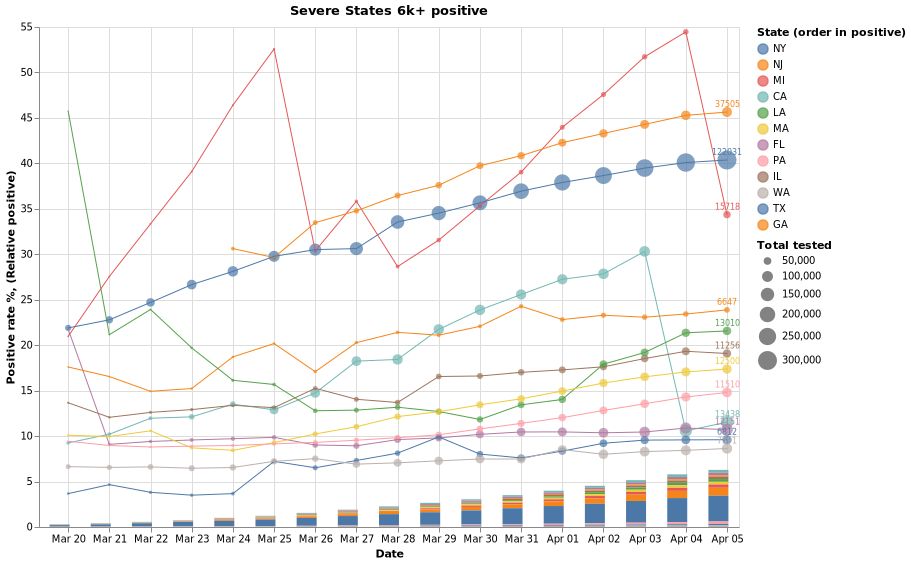

In [14]:
df_s |> 
@filter(_.date >= Date(2020, 3, 20) &&
    _.state ∈ unique(df_s[df_s.positive .> 6e3, :state])) |>
@mutate(pos_ratio = 100 * _.positive / _.totalTestResults) |> @filter(0 < _.pos_ratio < 70) |>
@vlplot()+
@vlplot(
    mark = {:circle, point=false, clip=false, tooltip=true},
    width=700, height=500,
    x = {:date, title="Date", timeUnit=:utcmonthdate},
    y = { :pos_ratio, scale={type="linear"}, title="Positive rate %" },
    size = {:total, title="Total tested"},
    color = {:state, sort= {op=:max, field=:positive, order=:descending}},
)+
@vlplot(
    mark = {:trail, style=:dashed, point=false, strokeDash=2},
    x = {:date,timeUnit=:utcmonthdate},
    y = {:pos_ratio, scale={type="linear"}},
    color = {:state, sort= {op=:max, field=:positive, order=:descending}},
    title = "Severe States 6k+ positive"
    
)+
@vlplot(
    mark={
        :text,
        dy = -7,
        fontSize=8
    },
    transform = [
        {
            calculate= "round(datum.positive)",
            as= "pr_str"
        },
        {
            filter= {field = :date, gt = vltime(now()-Day(2))}
        }
    ],
    x = {:date, timeUnit=:utcmonthdate},
    y = :pos_ratio,
    text = "positive:n",
    color = {:state, sort= {op=:max, field=:positive, order=:descending}},
)+
@vlplot(
    mark={
        :bar,
        width=20,
        height= 10,
        align=:center,
    },
    transform = [{
    calculate= "datum.positive/43000",
    as= "pr_str"
  }],
    x = {:date,timeUnit=:monthdate},
    y = {"pr_str:q", title="(Relative positive)"},
    color = {:state, sort= {op=:max, field=:positive, order=:descending}, title="State (order in positive)"},
)

In [15]:
df_s |> @filter(_.state == "CA" && _.date >= Date(2020, 4, 3)) |> DataFrame

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,hash,dateChecked,death,hospitalized,total,totalTestResults,posNeg,fips
,Date,String,Float64,Float64,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,String,String,Float64,Int64⍰,Float64,Int64,Int64,Int64
1,2020-04-05,CA,13438.0,103095.0,15000,2398,missing,1040,missing,missing,missing,missing,b16da92c388833be7769869d9eaf221dabbd9b20,2020-04-05T20:00:00Z,319.0,missing,131533.0,116533,116533,6
2,2020-04-04,CA,12026.0,101674.0,13000,2300,missing,1008,missing,missing,missing,missing,4a3edf69851dfa895e0e69e83fb57f41cd4c4a9f,2020-04-04T20:00:00Z,276.0,missing,126700.0,113700,113700,6
3,2020-04-03,CA,10701.0,24599.0,59500,2188,missing,901,missing,missing,missing,missing,67f105bfa3690e07b85e362a0c6c43aa796aba45,2020-04-03T20:00:00Z,237.0,missing,94800.0,35300,35300,6


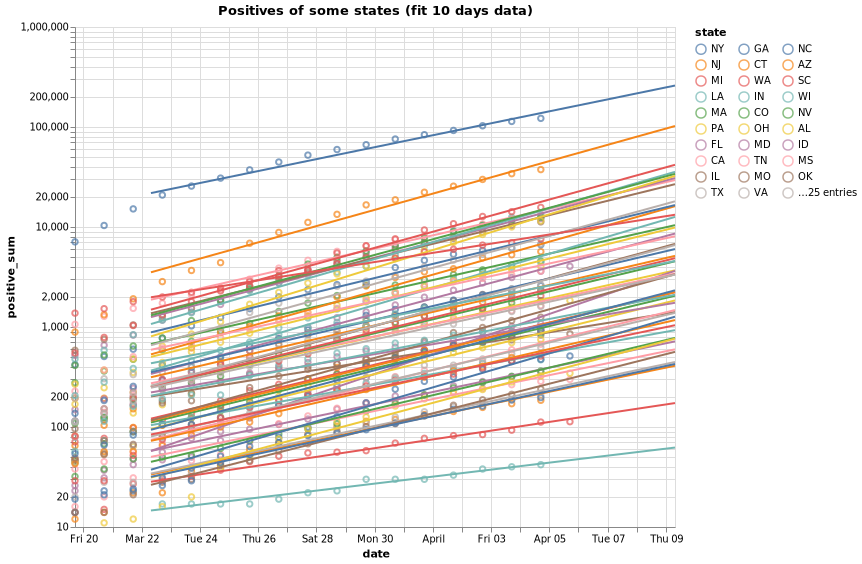

In [16]:
by(df_s, [:state, :date], :positive => sum) |> @filter(_.positive_sum >10 && _.date >= Date(2020,3,20)) |> 
# @filter(_.state ∈ ["CA", "NY", "NJ", "WA"]) |>
@vlplot(
    layer = [
        {
            :point,
            width = 600, height = 500,
            x = {:date, timeUnite=:monthdate},
            y = {:positive_sum, scale={type=:log}},
            title = "Positives of some states (fit 10 days data)"
        },
        {
            transform=[
                {
                    filter= {field = :date, gt = vltime(now()-Day(20))}
                },
                {
                
                    regression=:positive_sum,
                    on=:date,
                    groupby=[:state],
                    method=:exp,
                    extent=[vltime(now()-Day(15)), vltime(now()+Day(3))]
                }
            ],
            mark={:line, style=:dashed, strokeDash=1},
            x = {:date, timeUnite=:monthdate},
            y=:positive_sum,
        }
    ],
    color = {:state, sort= {op=:max, field=:positive_sum, order=:descending},
            legend={columns=3}},
        
)

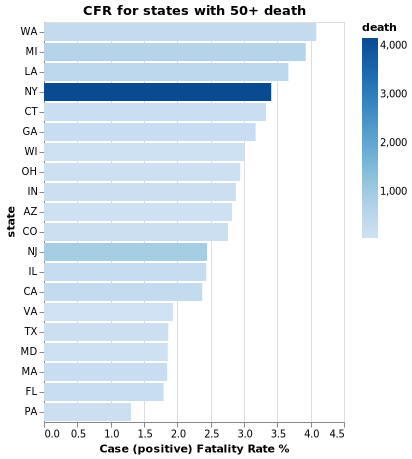

In [17]:
df_s |> 
@filter(_.date == df_s.date[1] && 
    _.state ∈ df_s[(df_s.death .> 50), :state]) |>
@mutate(death_ratio = 100 * _.death / _.positive) |>
@vlplot(
    width=300, height=400,
    y = {:state, sort="-x"},
    x = { :death_ratio, title="Case (positive) Fatality Rate %"},
    color = :death,
    layer = [
        {
            mark = {:bar, clip=false},
        },
#         {
#             {:text, dx=15},
#             text = {:death},
#         }
    ],

#     color = {:positive, legend={tickCount=10}},
    title = "CFR for states with 50+ death"
)

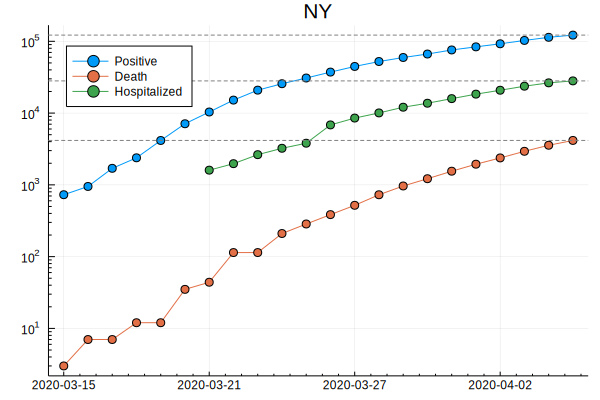

In [18]:
df_temp = df_s |> @filter(_.state == "NY" && _.death > 1) |> DataFrame
@df df_temp plot(:date, marker=true, [:positive, :death, :hospitalized], 
    label=["Positive" "Death" "Hospitalized"], yscale=:log10, minorticks=9)
hline!(maximum.([df_temp.positive, df_temp.death, skipmissing(df_temp.hospitalized)]), color=:grey, ls=:dash, label = "")
plot!(title = "NY", leg=:topleft)

# NYT COVID19

In [19]:
df_nyt = download("https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv") |>
CSV.File |> DataFrame

first(df_nyt, 3)

,date,county,state,fips,cases,deaths
,Date,String,String,Int64⍰,Int64,Int64
1,2020-01-21,Snohomish,Washington,53061,1,0
2,2020-01-22,Snohomish,Washington,53061,1,0
3,2020-01-23,Snohomish,Washington,53061,1,0


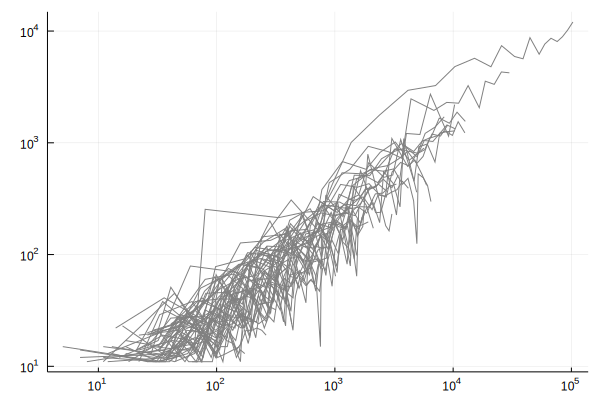

In [20]:
df_t = by(df_nyt, [:state, :date], :cases => sum)
df_t = sort(df_t, [:state, :date])

df_t = by(df_t, :state) do df
    (delta = [df.cases_sum[2:end] .- df.cases_sum[1:end-1];0], cases=df.cases_sum, date=df.date)
end

df_t = df_t |> @filter(_.date < today()-Day(2) && 
                _.delta > 10 #&&
#                 _.state ∈ ["California", "Michigan", "New York", "Massachusetts"]
    ) |> DataFrame

@df df_t plot(:cases, :delta, group=:state, color="grey", scale=:log10, leg=false)

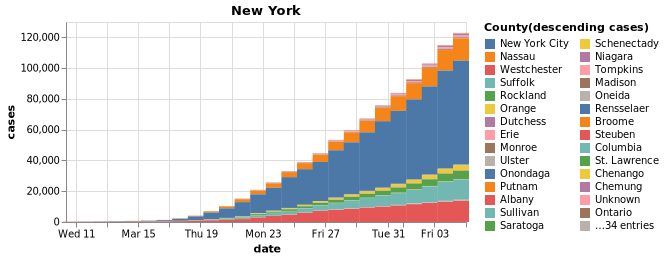

In [21]:
this_state = "New York"
df_nyt |> @filter(_.state == this_state && _.date > Date(2020, 3, 10)) |>
@vlplot(
    {:bar, width=16},
    width = 400, 
    x=:date,
    y=:cases,
    title = this_state,
    color = {
        :county, 
        legend={columns=2}, 
        sort={op=:max, field=:cases, order=:descending},
        title="County(descending cases)"
    }
)

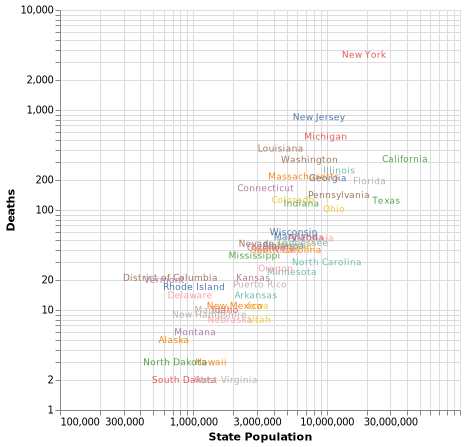

In [22]:
df_cross = CSV.File("US_state_ages.csv") |> DataFrame |> @select(:state, :total) |> DataFrame;
df_temp = join(df_cross, df_nyt, on=:state) 
by(df_temp, [:state, :date, :total], :deaths => sum) |> @filter( _.deaths_sum>0 && _.date == today()-Day(2))|>
@vlplot(
    width = 400, height = 400,
    mark={
        :text,
        fontSize=9
    },
    
    y = {:deaths_sum, scale={type=:log}, title = "Deaths"},
    x = {:total, scale={type=:log}, title="State Population"},
    color = {:state, legend=false},
    text=:state,
)

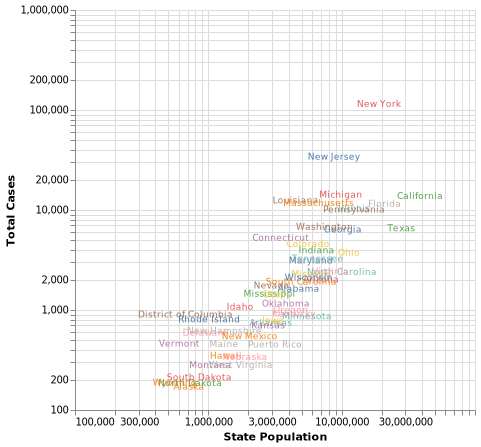

In [23]:
by(df_temp, [:state, :date, :total], :cases => sum) |> @filter( _.cases_sum>0 && _.date == today()-Day(2))|>
@vlplot(
    width = 400, height = 400,
    mark={
        :text,
        fontSize=9
    },
    y = {:cases_sum, scale={type=:log}, title = "Total Cases"},
    x = {:total, scale={type=:log}, title="State Population"},
    color = {:state, legend=false},
    text=:state,
)

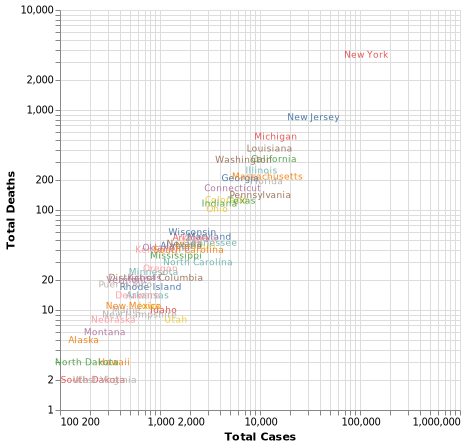

In [24]:
by(df_temp, [:state, :date, :total], :cases => sum, :deaths => sum) |> @filter( _.deaths_sum>1 && _.date == today()-Day(2))|>
@vlplot(
    width = 400, height = 400,
    mark={
        :text,
        fontSize=9
    },
    x = {:cases_sum, scale={type=:log}, title = "Total Cases"},
    y = {:deaths_sum, scale={type=:log}, title="Total Deaths"},
    color = {:state, legend=false},
    text=:state,
)

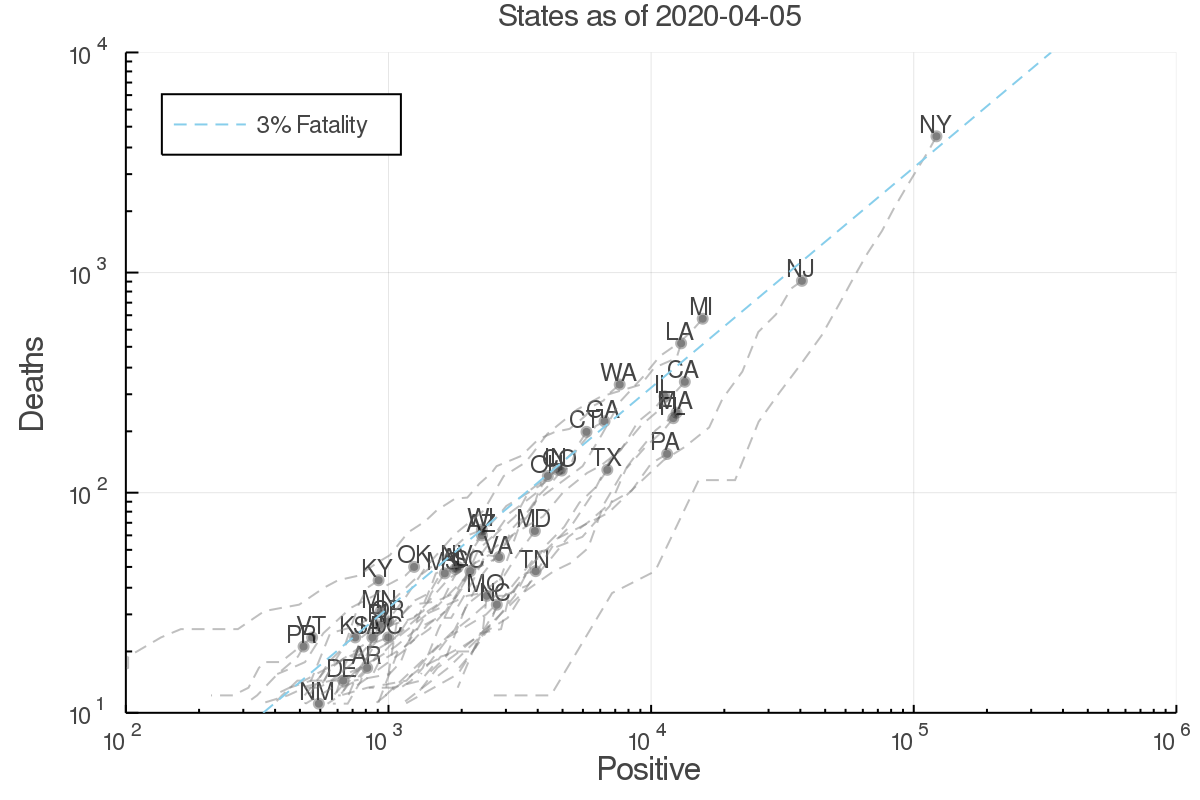

In [25]:

function wee_state(da)
    df_temp = df_s |> @filter(_.positive >10 && _.death >10 && _.date <= da)
    plot(
        title = "States as of $da",
        titlefont = 10,
        size = (600, 400),
        xlabel = "Positive",
        ylabel = "Deaths", 
        xscale=:log10,
        yscale=:log10,
        xlims = (1e2, 1e6),
        ylims = (1e1, 1e4),
        minorticks = 10,
        dpi = 200,
        fmt=:png
    )
    @df df_temp |> @filter(_.date == da) scatter!(:positive, :death, color = "black", markeralpha=0.3, markersize=2.5, series_annotations=[Plots.text(x,:bottom, 8) for x in :state], group=:state, label="")
    @df df_temp plot!(:positive, :death, ls=:dash, color = "grey", group=:state, alpha=0.5, label="")
end

# anim = @animate for da in range(Date(2020, 3,10), df_s.date[1], step=Day(1))
#     wee_state(da)
#     df_temp = df_s |> @filter( _.state == "NY" && _.date <= da)
#     @df df_temp |> scatter!(:positive, :death, color = "red", markersize=2.5, series_annotations=[Plots.text(x,:bottom, 8) for x in :state], group=:state, label="")
#     @df df_temp plot!(:positive, :death, ls=:dash, color = "red", group=:state, alpha=0.5)
# end
# gif(anim, fps = 2)
wee_state(df_s.date[1])
plot!(x->0.03*x,  ls=:dash, color = "skyblue", label = "3% Fatality", leg=:topleft)

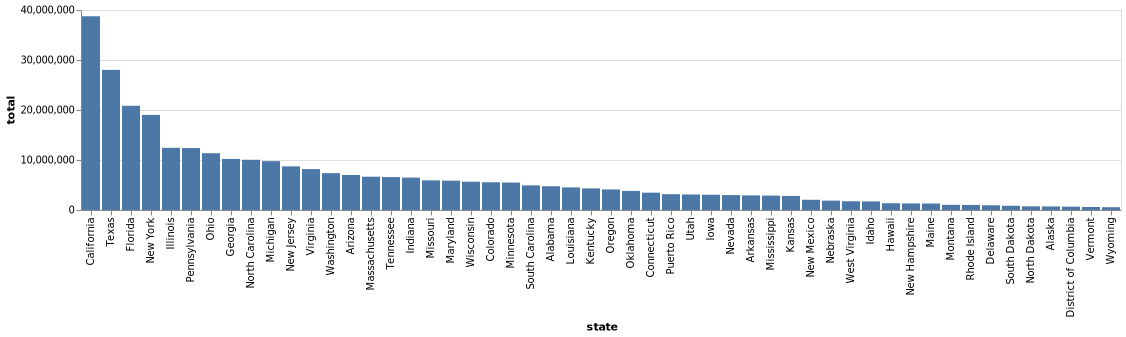

In [26]:
df_cross |>
@vlplot(
    :bar,
    x={:state, sort="-y"},
    y=:total, 
)